### installations

In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install moviepy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# University of Aberdeen

## Applied AI (CS5079)

### Resit CA1 - Reinforcement Learning with OpenAI Gym

In [1]:
#Library for environments
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

#Librairies to represent the output
from IPython.display import clear_output, HTML
import time
import matplotlib.pyplot as plt

#Essential libraries for computation
import numpy as np
import random
# import tensorflow.compat.v1 as tf
from collections import deque


We will use the following environment.

In [2]:
# random_map = generate_random_map(size=10, p=0.3)
# env = gym.make("FrozenLake-v1", desc=random_map)
# env.reset()
# env.render()

In [3]:
import imageio
import io
import base64

In [ ]:
# Parameters
state_size = env.observation_space.n  # Number of states
action_size = env.action_space.n      # Number of actions
learning_rate = 0.001

# Define placeholders for states and target Q-values
tf.disable_eager_execution()
tf.reset_default_graph()
states = tf.placeholder(tf.float32, [None, state_size], name="states")
q_target = tf.placeholder(tf.float32, [None, action_size], name="q_target")

# Neural network architecture
fc1 = tf.keras.layers.Dense(24, activation='relu')(states)
fc2 = tf.keras.layers.Dense(24, activation='relu')(fc1)
output = tf.keras.layers.Dense(action_size, activation=None)(fc2)  # Q-values for each action

# Loss and optimizer
loss = tf.reduce_mean(tf.square(q_target - output))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


In [ ]:
# Experience replay parameters
memory_size = 2000
batch_size = 64
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))


In [ ]:
epsilon = 1.0        # Exploration rate (starts high)
epsilon_min = 0.1   # Minimum exploration rate
epsilon_decay = 0.9959 # Decay rate for epsilon

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    q_values = sess.run(output, feed_dict={states: state})
    return np.argmax(q_values[0])  # Best action based on Q-values


In [ ]:
num_episodes = 3000  # Number of episodes to train
gamma = 0.99         # Discount factor

# TensorFlow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    state = np.identity(state_size)[state:state+1]  # One-hot encoding of initial state
    total_reward = 0

    for step in range(100):
        # Choose action
        action = choose_action(state, epsilon)

        # Take action and observe results
        next_state, reward, done, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  # One-hot encoding of next state

        # Store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state
        total_reward += reward

        # Sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = np.array([exp[0][0] for exp in minibatch])
            actions_mb = [exp[1] for exp in minibatch]
            rewards_mb = [exp[2] for exp in minibatch]
            next_states_mb = np.array([exp[3][0] for exp in minibatch])
            dones_mb = [exp[4] for exp in minibatch]

            # Predict Q-values for next states
            target_qs = sess.run(output, feed_dict={states: next_states_mb})
            targets_mb = sess.run(output, feed_dict={states: states_mb})

            for i in range(batch_size):
                if dones_mb[i]:
                    targets_mb[i][actions_mb[i]] = rewards_mb[i]
                else:
                    targets_mb[i][actions_mb[i]] = rewards_mb[i] + gamma * np.amax(target_qs[i])

            # Update the network with the new targets
            sess.run(optimizer, feed_dict={states: states_mb, q_target: targets_mb})

        if done:
            break

    # Decay epsilon
    epsilon *= epsilon_decay
    if epsilon < epsilon_min:
        epsilon = epsilon_min

    # Display results occasionally
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")

print("Training completed.")



RuntimeError: The Session graph is empty. Add operations to the graph before calling run().

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Progress:   0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationW

Episode: 100, Total Reward: 0.0, Epsilon: 0.9900493386913721


Progress:   2%|▏         | 199/10000 [00:26<26:33,  6.15it/s]

Episode: 200, Total Reward: 0.0, Epsilon: 0.980197693043223


Progress:   3%|▎         | 300/10000 [00:39<30:22,  5.32it/s]

Episode: 300, Total Reward: 0.0, Epsilon: 0.970444077784251


Progress:   4%|▍         | 400/10000 [01:00<18:52,  8.47it/s]

Episode: 400, Total Reward: 0.0, Epsilon: 0.9607875174472562


Progress:   5%|▌         | 502/10000 [01:16<17:08,  9.24it/s]

Episode: 500, Total Reward: 0.0, Epsilon: 0.9512270462715811


Progress:   6%|▌         | 600/10000 [01:32<34:31,  4.54it/s]

Episode: 600, Total Reward: 0.0, Epsilon: 0.9417617081065252


Progress:   7%|▋         | 700/10000 [01:50<23:55,  6.48it/s]

Episode: 700, Total Reward: 0.0, Epsilon: 0.9323905563157222


Progress:   8%|▊         | 801/10000 [02:06<15:13, 10.07it/s]

Episode: 800, Total Reward: 0.0, Epsilon: 0.9231126536824614


Progress:   9%|▉         | 902/10000 [02:21<22:34,  6.72it/s]

Episode: 900, Total Reward: 0.0, Epsilon: 0.9139270723159584


Progress:  10%|█         | 1002/10000 [02:35<11:03, 13.56it/s]

Episode: 1000, Total Reward: 0.0, Epsilon: 0.9048328935585562


Progress:  11%|█         | 1102/10000 [02:52<20:52,  7.10it/s]

Episode: 1100, Total Reward: 0.0, Epsilon: 0.8958292078938495


Progress:  12%|█▏        | 1202/10000 [03:11<14:27, 10.14it/s]

Episode: 1200, Total Reward: 0.0, Epsilon: 0.886915114855721


Progress:  13%|█▎        | 1301/10000 [03:27<15:00,  9.66it/s]

Episode: 1300, Total Reward: 0.0, Epsilon: 0.8780897229382887


Progress:  14%|█▍        | 1401/10000 [03:45<23:11,  6.18it/s]

Episode: 1400, Total Reward: 0.0, Epsilon: 0.8693521495067424


Progress:  15%|█▌        | 1501/10000 [04:02<28:35,  4.95it/s]

Episode: 1500, Total Reward: 0.0, Epsilon: 0.8607015207090729


Progress:  16%|█▌        | 1602/10000 [04:18<13:34, 10.31it/s]

Episode: 1600, Total Reward: 0.0, Epsilon: 0.8521369713886755


Progress:  17%|█▋        | 1701/10000 [04:33<17:31,  7.89it/s]

Episode: 1700, Total Reward: 0.0, Epsilon: 0.843657644997827


Progress:  18%|█▊        | 1800/10000 [04:50<21:32,  6.34it/s]

Episode: 1800, Total Reward: 0.0, Epsilon: 0.8352626935120188


Progress:  19%|█▉        | 1898/10000 [05:06<22:11,  6.09it/s]

Episode: 1900, Total Reward: 0.0, Epsilon: 0.8269512773451482


Progress:  20%|██        | 2000/10000 [05:23<25:00,  5.33it/s]

Episode: 2000, Total Reward: 0.0, Epsilon: 0.8187225652655491


Progress:  21%|██        | 2101/10000 [05:39<16:49,  7.83it/s]

Episode: 2100, Total Reward: 0.0, Epsilon: 0.8105757343128605


Progress:  22%|██▏       | 2201/10000 [05:56<19:39,  6.61it/s]

Episode: 2200, Total Reward: 0.0, Epsilon: 0.8025099697157205


Progress:  23%|██▎       | 2299/10000 [06:15<19:11,  6.69it/s]

Episode: 2300, Total Reward: 0.0, Epsilon: 0.7945244648102819


Progress:  24%|██▍       | 2401/10000 [06:31<17:49,  7.10it/s]

Episode: 2400, Total Reward: 0.0, Epsilon: 0.7866184209595359


Progress:  25%|██▌       | 2500/10000 [06:47<20:08,  6.21it/s]

Episode: 2500, Total Reward: 0.0, Epsilon: 0.7787910474734399


Progress:  26%|██▌       | 2600/10000 [07:05<21:47,  5.66it/s]

Episode: 2600, Total Reward: 0.0, Epsilon: 0.7710415615298397


Progress:  27%|██▋       | 2699/10000 [07:23<27:00,  4.50it/s]

Episode: 2700, Total Reward: 0.0, Epsilon: 0.7633691880961806


Progress:  28%|██▊       | 2800/10000 [07:40<23:45,  5.05it/s]

Episode: 2800, Total Reward: 0.0, Epsilon: 0.7557731598519929


Progress:  29%|██▉       | 2899/10000 [07:58<23:09,  5.11it/s]

Episode: 2900, Total Reward: 0.0, Epsilon: 0.748252717112154


Progress:  30%|███       | 3001/10000 [08:15<16:38,  7.01it/s]

Episode: 3000, Total Reward: 0.0, Epsilon: 0.74080710775091


Progress:  31%|███       | 3101/10000 [08:30<15:33,  7.39it/s]

Episode: 3100, Total Reward: 0.0, Epsilon: 0.7334355871266565


Progress:  32%|███▏      | 3201/10000 [08:49<27:22,  4.14it/s]

Episode: 3200, Total Reward: 0.0, Epsilon: 0.7261374180074647


Progress:  33%|███▎      | 3301/10000 [09:07<32:13,  3.46it/s]

Episode: 3300, Total Reward: 0.0, Epsilon: 0.7189118704973512


Progress:  34%|███▍      | 3400/10000 [09:24<23:27,  4.69it/s]

Episode: 3400, Total Reward: 1.0, Epsilon: 0.7117582219632792


Progress:  35%|███▍      | 3499/10000 [09:41<24:17,  4.46it/s]

Episode: 3500, Total Reward: 0.0, Epsilon: 0.7046757569628911


Progress:  36%|███▌      | 3600/10000 [10:01<16:24,  6.50it/s]

Episode: 3600, Total Reward: 0.0, Epsilon: 0.697663767172952


Progress:  37%|███▋      | 3700/10000 [10:17<11:57,  8.77it/s]

Episode: 3700, Total Reward: 0.0, Epsilon: 0.6907215513185129


Progress:  38%|███▊      | 3801/10000 [10:37<28:49,  3.58it/s]

Episode: 3800, Total Reward: 0.0, Epsilon: 0.6838484151027725


Progress:  39%|███▉      | 3900/10000 [10:54<17:17,  5.88it/s]

Episode: 3900, Total Reward: 0.0, Epsilon: 0.6770436711376424


Progress:  40%|████      | 4001/10000 [11:09<14:13,  7.03it/s]

Episode: 4000, Total Reward: 0.0, Epsilon: 0.6703066388750015


Progress:  41%|████      | 4099/10000 [11:25<16:39,  5.91it/s]

Episode: 4100, Total Reward: 0.0, Epsilon: 0.6636366445386316


Progress:  42%|████▏     | 4200/10000 [11:40<16:23,  5.90it/s]

Episode: 4200, Total Reward: 0.0, Epsilon: 0.657033021056833


Progress:  43%|████▎     | 4304/10000 [11:54<08:54, 10.66it/s]

Episode: 4300, Total Reward: 0.0, Epsilon: 0.6504951079957114


Progress:  44%|████▍     | 4401/10000 [12:09<09:38,  9.68it/s]

Episode: 4400, Total Reward: 0.0, Epsilon: 0.6440222514931265


Progress:  45%|████▌     | 4501/10000 [12:26<15:50,  5.78it/s]

Episode: 4500, Total Reward: 0.0, Epsilon: 0.6376138041932984


Progress:  46%|████▌     | 4601/10000 [12:43<11:07,  8.09it/s]

Episode: 4600, Total Reward: 0.0, Epsilon: 0.6312691251820646


Progress:  47%|████▋     | 4701/10000 [13:05<13:52,  6.36it/s]

Episode: 4700, Total Reward: 0.0, Epsilon: 0.6249875799227835


Progress:  48%|████▊     | 4800/10000 [13:23<10:41,  8.11it/s]

Episode: 4800, Total Reward: 0.0, Epsilon: 0.6187685401928729


Progress:  49%|████▉     | 4901/10000 [13:40<10:36,  8.01it/s]

Episode: 4900, Total Reward: 0.0, Epsilon: 0.6126113840209793


Progress:  50%|█████     | 5001/10000 [13:56<14:22,  5.80it/s]

Episode: 5000, Total Reward: 0.0, Epsilon: 0.6065154956247766


Progress:  51%|█████     | 5101/10000 [14:08<09:06,  8.97it/s]

Episode: 5100, Total Reward: 0.0, Epsilon: 0.6004802653493791


Progress:  52%|█████▏    | 5201/10000 [14:25<12:34,  6.36it/s]

Episode: 5200, Total Reward: 0.0, Epsilon: 0.594505089606372


Progress:  53%|█████▎    | 5301/10000 [14:43<16:47,  4.66it/s]

Episode: 5300, Total Reward: 0.0, Epsilon: 0.5885893708134431


Progress:  54%|█████▍    | 5402/10000 [14:59<07:31, 10.18it/s]

Episode: 5400, Total Reward: 0.0, Epsilon: 0.5827325173346204


Progress:  55%|█████▌    | 5501/10000 [15:17<11:15,  6.66it/s]

Episode: 5500, Total Reward: 0.0, Epsilon: 0.5769339434210992


Progress:  56%|█████▌    | 5601/10000 [15:32<07:52,  9.32it/s]

Episode: 5600, Total Reward: 0.0, Epsilon: 0.5711930691526644


Progress:  57%|█████▋    | 5699/10000 [15:50<12:49,  5.59it/s]

Episode: 5700, Total Reward: 0.0, Epsilon: 0.565509320379691


Progress:  58%|█████▊    | 5800/10000 [16:08<10:21,  6.75it/s]

Episode: 5800, Total Reward: 0.0, Epsilon: 0.5598821286657205


Progress:  59%|█████▉    | 5900/10000 [16:26<10:47,  6.33it/s]

Episode: 5900, Total Reward: 0.0, Epsilon: 0.5543109312306146


Progress:  60%|██████    | 6000/10000 [16:46<08:46,  7.59it/s]

Episode: 6000, Total Reward: 0.0, Epsilon: 0.5487951708942683


Progress:  61%|██████    | 6099/10000 [17:02<07:35,  8.56it/s]

Episode: 6100, Total Reward: 0.0, Epsilon: 0.5433342960208886


Progress:  62%|██████▏   | 6202/10000 [17:17<07:10,  8.83it/s]

Episode: 6200, Total Reward: 0.0, Epsilon: 0.5379277604638235


Progress:  63%|██████▎   | 6300/10000 [17:32<10:03,  6.13it/s]

Episode: 6300, Total Reward: 0.0, Epsilon: 0.5325750235109391


Progress:  64%|██████▍   | 6401/10000 [17:48<12:07,  4.95it/s]

Episode: 6400, Total Reward: 0.0, Epsilon: 0.5272755498305473


Progress:  65%|██████▌   | 6501/10000 [18:05<10:12,  5.72it/s]

Episode: 6500, Total Reward: 0.0, Epsilon: 0.5220288094178624


Progress:  66%|██████▌   | 6600/10000 [18:19<06:02,  9.37it/s]

Episode: 6600, Total Reward: 0.0, Epsilon: 0.5168342775419988


Progress:  67%|██████▋   | 6701/10000 [18:36<07:39,  7.18it/s]

Episode: 6700, Total Reward: 0.0, Epsilon: 0.5116914346934888


Progress:  68%|██████▊   | 6800/10000 [18:51<04:25, 12.05it/s]

Episode: 6800, Total Reward: 0.0, Epsilon: 0.506599766532328


Progress:  69%|██████▉   | 6901/10000 [19:05<05:55,  8.72it/s]

Episode: 6900, Total Reward: 0.0, Epsilon: 0.5015587638365347


Progress:  70%|███████   | 7000/10000 [19:22<10:45,  4.65it/s]

Episode: 7000, Total Reward: 0.0, Epsilon: 0.496567922451223


Progress:  71%|███████   | 7101/10000 [19:40<09:52,  4.89it/s]

Episode: 7100, Total Reward: 0.0, Epsilon: 0.4916267432381818


Progress:  72%|███████▏  | 7203/10000 [19:55<04:26, 10.49it/s]

Episode: 7200, Total Reward: 0.0, Epsilon: 0.4867347320259549


Progress:  73%|███████▎  | 7302/10000 [20:10<05:20,  8.41it/s]

Episode: 7300, Total Reward: 0.0, Epsilon: 0.48189139956041893


Progress:  74%|███████▍  | 7399/10000 [20:26<07:13,  5.99it/s]

Episode: 7400, Total Reward: 0.0, Epsilon: 0.4770962614558525


Progress:  75%|███████▌  | 7501/10000 [20:46<05:24,  7.70it/s]

Episode: 7500, Total Reward: 0.0, Epsilon: 0.4723488381464926


Progress:  76%|███████▌  | 7600/10000 [21:02<08:40,  4.61it/s]

Episode: 7600, Total Reward: 0.0, Epsilon: 0.467648654838573


Progress:  77%|███████▋  | 7699/10000 [21:17<07:07,  5.38it/s]

Episode: 7700, Total Reward: 0.0, Epsilon: 0.46299524146283894


Progress:  78%|███████▊  | 7801/10000 [21:34<05:33,  6.59it/s]

Episode: 7800, Total Reward: 0.0, Epsilon: 0.4583881326275357


Progress:  79%|███████▉  | 7900/10000 [21:51<05:44,  6.10it/s]

Episode: 7900, Total Reward: 0.0, Epsilon: 0.45382686757186447


Progress:  80%|████████  | 8000/10000 [22:06<05:43,  5.83it/s]

Episode: 8000, Total Reward: 0.0, Epsilon: 0.4493109901199013


Progress:  81%|████████  | 8102/10000 [22:24<04:08,  7.65it/s]

Episode: 8100, Total Reward: 0.0, Epsilon: 0.44484004863497356


Progress:  82%|████████▏ | 8201/10000 [22:41<03:35,  8.34it/s]

Episode: 8200, Total Reward: 0.0, Epsilon: 0.4404135959744933


Progress:  83%|████████▎ | 8300/10000 [22:53<03:20,  8.48it/s]

Episode: 8300, Total Reward: 0.0, Epsilon: 0.4360311894452362


Progress:  84%|████████▍ | 8403/10000 [23:08<02:18, 11.54it/s]

Episode: 8400, Total Reward: 0.0, Epsilon: 0.4316923907590687


Progress:  85%|████████▌ | 8502/10000 [23:23<02:53,  8.63it/s]

Episode: 8500, Total Reward: 0.0, Epsilon: 0.42739676598911336


Progress:  86%|████████▌ | 8603/10000 [23:36<01:58, 11.83it/s]

Episode: 8600, Total Reward: 0.0, Epsilon: 0.42314388552635285


Progress:  87%|████████▋ | 8701/10000 [23:49<03:47,  5.72it/s]

Episode: 8700, Total Reward: 0.0, Epsilon: 0.4189333240366638


Progress:  88%|████████▊ | 8802/10000 [24:02<03:09,  6.31it/s]

Episode: 8800, Total Reward: 0.0, Epsilon: 0.41476466041827703


Progress:  89%|████████▉ | 8902/10000 [24:18<01:45, 10.36it/s]

Episode: 8900, Total Reward: 0.0, Epsilon: 0.41063747775966636


Progress:  90%|█████████ | 9001/10000 [24:34<01:45,  9.47it/s]

Episode: 9000, Total Reward: 0.0, Epsilon: 0.4065513632978508


Progress:  91%|█████████ | 9100/10000 [24:50<02:45,  5.44it/s]

Episode: 9100, Total Reward: 0.0, Epsilon: 0.40250590837711264


Progress:  92%|█████████▏| 9201/10000 [25:08<01:51,  7.17it/s]

Episode: 9200, Total Reward: 0.0, Epsilon: 0.39850070840813034


Progress:  93%|█████████▎| 9301/10000 [25:22<01:24,  8.26it/s]

Episode: 9300, Total Reward: 0.0, Epsilon: 0.39453536282751267


Progress:  94%|█████████▍| 9401/10000 [25:38<01:34,  6.36it/s]

Episode: 9400, Total Reward: 0.0, Epsilon: 0.3906094750577395


Progress:  95%|█████████▌| 9500/10000 [25:55<01:35,  5.21it/s]

Episode: 9500, Total Reward: 0.0, Epsilon: 0.3867226524674988


Progress:  96%|█████████▌| 9601/10000 [26:11<01:09,  5.72it/s]

Episode: 9600, Total Reward: 0.0, Epsilon: 0.38287450633242015


Progress:  97%|█████████▋| 9701/10000 [26:30<00:38,  7.75it/s]

Episode: 9700, Total Reward: 0.0, Epsilon: 0.3790646517961982


Progress:  98%|█████████▊| 9799/10000 [26:48<00:27,  7.23it/s]

Episode: 9800, Total Reward: 0.0, Epsilon: 0.375292707832101


Progress:  99%|█████████▉| 9901/10000 [27:04<00:13,  7.32it/s]

Episode: 9900, Total Reward: 0.0, Epsilon: 0.37155829720486555


Progress: 100%|██████████| 10000/10000 [27:19<00:00,  6.10it/s]


Episode: 10000, Total Reward: 1.0, Epsilon: 0.3678610464329692
Training completed.


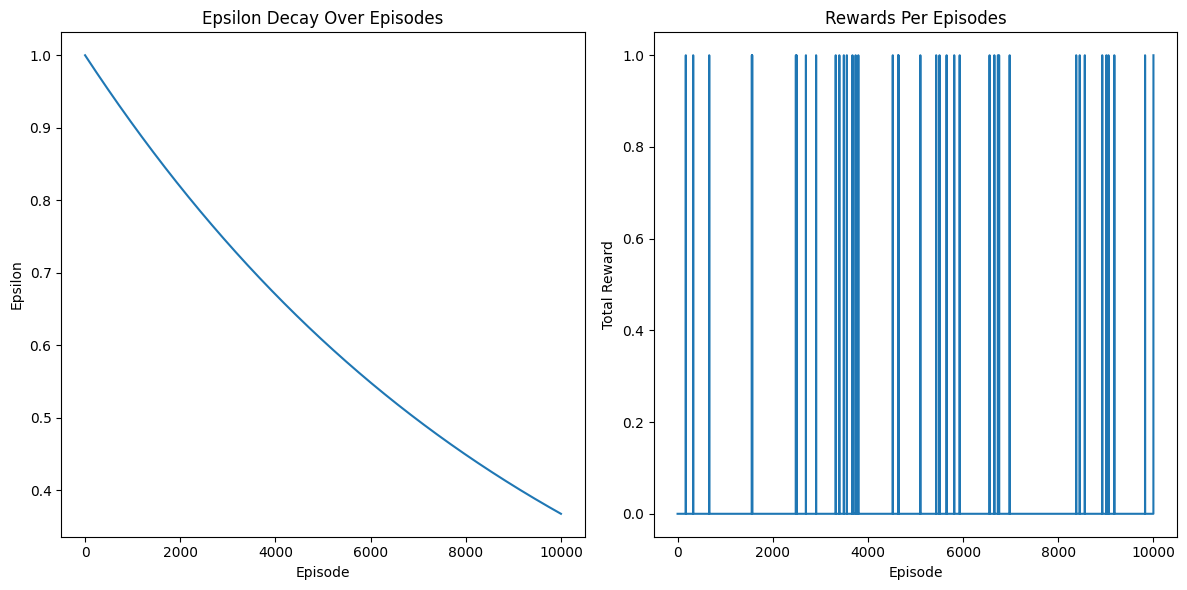

In [ ]:
# Libraries for environments
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

# Libraries for output display and plotting
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import tqdm

# Generate a random map and create the Frozen Lake environment with `is_slippery=True`
random_map = generate_random_map(size=7, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# Wrap the environment with RecordVideo to capture video after training
env = gym.wrappers.RecordVideo(env, video_folder='./video', episode_trigger=lambda x: x == num_episodes - 1)

# Parameters
state_size = env.observation_space.n  # Number of states
action_size = env.action_space.n      # Number of actions
learning_rate = 0.001

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Initialize the DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Experience replay parameters
memory_size = 50000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# Epsilon-greedy parameters
epsilon = 1.0        # Exploration rate (starts high)
epsilon_min = 0.1    # Minimum exploration rate
epsilon_decay = 0.9999 # Decay rate for epsilon

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # Best action based on Q-values

# Training parameters
num_episodes = 10000  # Number of episodes to train
gamma = 0.99         # Discount factor

epsilon_values = []
reward_values = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state = env.reset()
    state = np.identity(state_size)[state:state+1]  # One-hot encoding of initial state
    total_reward = 0
    done = False

    for step in range(100):
        # Choose action
        action = choose_action(state, epsilon)

        # Take action and observe results
        next_state, reward, done, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  # One-hot encoding of next state

        # Modified reward structure example
        if done and reward == 0:  # Fell into a hole
            reward = 0
        elif done and reward == 1:  # Reached the goal
            reward = 1

        # Store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state
        total_reward += reward

        # Sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # Predict Q-values for current states and next states
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # Compute target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            # Compute the loss and update the network
            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Store values
    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    # Display results occasionally
    if (episode + 1) % 100 == 0:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

print("Training completed.")

# Plotting
plt.figure(figsize=(12, 6))

# Plot epsilon values
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# Plot reward values
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()


In [ ]:
# Run a post-training episode to capture video
state = env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # Exploit learned policy
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  # Display final reward

# Function to display the video in Jupyter Notebook
def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')

# Locate the recorded video
import os
from pathlib import Path

video_path = sorted(Path('./video').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

Total Reward in test episode: 0.0


<ipython-input-11-e307aa12fda5>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = model(torch.tensor(state, dtype=torch.float32))


In [ ]:
# Libraries for environments
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

# Libraries for output display and plotting
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import HTML
import base64
import os


video_folder = './video'
if os.path.exists(video_folder):
    import shutil
    shutil.rmtree(video_folder)
os.makedirs(video_folder, exist_ok=True)

global recording
recording = False

global successes
successes = set()

# Generate a random map and create the Frozen Lake environment with `is_slippery=True`
random_map = generate_random_map(size=4, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

def record_working(episode_num):
    return episode_num in successes

# Wrap the environment with RecordVideo to capture video after training
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=record_working)

# Parameters
state_size = env.observation_space.n  # Number of states
action_size = env.action_space.n      # Number of actions
learning_rate = 0.001

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Initialize the DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Experience replay parameters
memory_size = 1000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# Epsilon-greedy parameters
epsilon = 1.0        # Exploration rate (starts high)
epsilon_min = 0.1    # Minimum exploration rate
epsilon_decay = 0.999 # Decay rate for epsilon

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # Best action based on Q-values

# Training parameters
num_episodes = 1000  # Number of episodes to train
gamma = 0.99         # Discount factor

epsilon_values = []
reward_values = []

recorded_rewards = {}

# Training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state = env.reset()
    state = np.identity(state_size)[state:state+1]  # One-hot encoding of initial state
    total_reward = 0
    done = False

    successful = False

    for step in range(100):
        # Choose action
        action = choose_action(state, epsilon)

        # Take action and observe results
        next_state, reward, done, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  # One-hot encoding of next state

        if done and reward == 1:
            successful = True

        # Store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state
        total_reward += reward

        # Sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # Predict Q-values for current states and next states
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # Compute target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            # Compute the loss and update the network
            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Store values
    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    if successful:
        successes.add(episode)
        tqdm.write(f"Successful Episode: {episode}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")
        recorded_rewards[episode] = total_reward

    # Display results occasionally
    if total_reward == 1:  # Print only successful episodes where reward is 1
      tqdm.write(f"Successful Episode: {episode}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")


print("Training completed.")

# Plotting
plt.figure(figsize=(12, 6))

# Plot epsilon values
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# Plot reward values
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Progress:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWa

Successful Episode: 564, Total Reward: 1.0, Epsilon: 0.5681995006020529
Successful Episode: 564, Total Reward: 1.0, Epsilon: 0.5681995006020529


Progress:  59%|█████▉    | 588/1000 [01:01<01:00,  6.76it/s]

Successful Episode: 587, Total Reward: 1.0, Epsilon: 0.5552736652928869
Successful Episode: 587, Total Reward: 1.0, Epsilon: 0.5552736652928869


Progress:  83%|████████▎ | 830/1000 [01:35<00:19,  8.71it/s]


KeyboardInterrupt: 

In [ ]:
# # Run a post-training episode to capture video
# state = env.reset()
# done = False
# total_reward = 0

# while not done:
#     state_tensor = torch.tensor(np.eye(state_size)[state], dtype=torch.float32)
#     action = choose_action(state_tensor, epsilon=0.1)  # Exploit learned policy
#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward
#     state = next_state

# env.close()
# print(f"Total Reward in test episode: {total_reward}")  # Display final reward

# # Display the video
# def display_video(video_path):
#     with open(video_path, 'rb') as video_file:
#         video = video_file.read()
#     encoded = base64.b64encode(video).decode('ascii')
#     return HTML(data=f'''
#         <video width="640" height="480" controls>
#             <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
#         </video>
#     ''')

# # Locate the recorded video and display it
# video_path = sorted(Path('./video').glob("*.mp4"), key=os.path.getmtime)[-1]
# display_video(str(video_path))

In [ ]:
successful_videos = [video for video, reward in recorded_rewards.items() if reward == 1]
if successful_videos:
    last_successful_video = sorted(successful_videos)[-1]
    print(f"Last successful video: {last_successful_video}")

    def display_video(video_path):
        with open(video_path, 'rb') as video_file:
            video = video_file.read()
        encoded = base64.b64encode(video).decode('ascii')
        return HTML(data=f'''
            <video width="640" height="480" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>
        ''')

    # Display the video
    display_video(str(video_path))
else:
    print("No successful videos found.")

Last successful video: episode_993.mp4


FileNotFoundError: [Errno 2] No such file or directory: 'video/rl-video-episode-824.mp4'

# WORKING !!!!!!!!!!!!!!!!!

### 4x4

In [7]:
# # delete video folder
# import shutil
# folder_path = "./video"  # Adjust this to the exact path of the folder
# shutil.rmtree(folder_path)

Progress: 100%|█████████████████████████████| 5000/5000 [02:57<00:00, 28.13it/s]


Training completed.


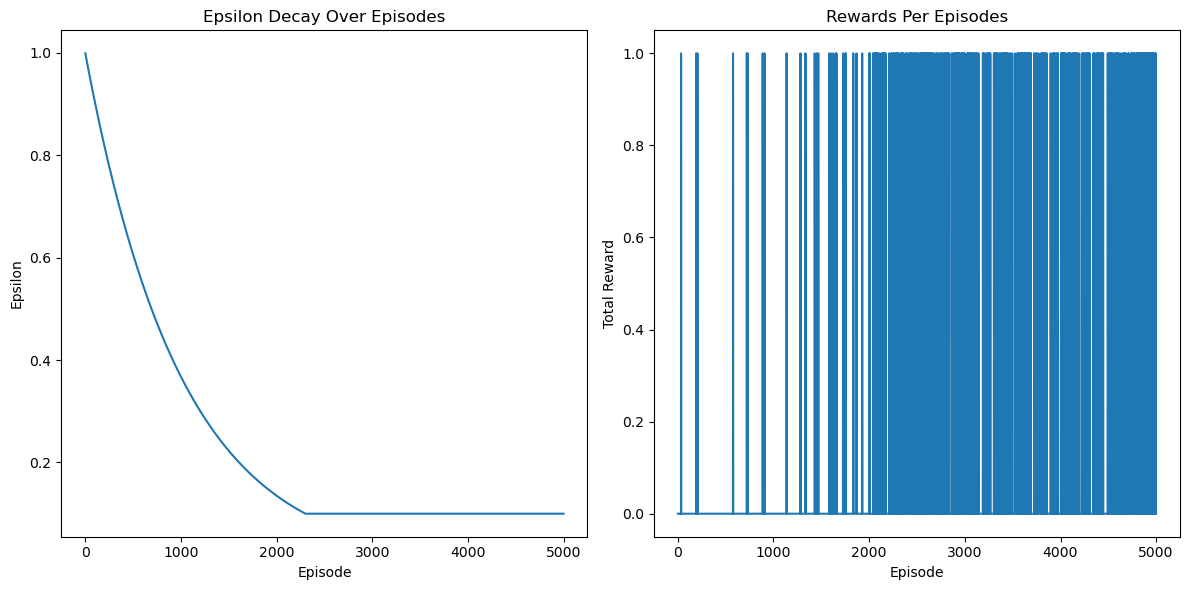

In [10]:
# Libraries for environments
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

# Libraries for output display and plotting
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

# Generate a random map and create the Frozen Lake environment with is_slippery=True
random_map = generate_random_map(size=4, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# Wrap the environment with RecordVideo to capture video after training
# env = gym.wrappers.RecordVideo(env, video_folder='./video', episode_trigger=lambda x: (x+1) % 10 == 0)

# Parameters
state_size = env.observation_space.n  # Number of states
action_size = env.action_space.n      # Number of actions
learning_rate = 0.001

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Initialize the DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Experience replay parameters
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# Epsilon-greedy parameters
epsilon = 1.0        # Exploration rate (starts high)
epsilon_min = 0.1    # Minimum exploration rate
epsilon_decay = 0.999 # Decay rate for epsilon

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # Best action based on Q-values

# Training parameters
num_episodes = 5000  # Number of episodes to train
gamma = 0.99         # Discount factor

epsilon_values = []
reward_values = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # One-hot encoding of initial state
    total_reward = 0
    done = False

    for step in range(100):
        # Choose action
        action = choose_action(state, epsilon)

        # Take action and observe results
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  # One-hot encoding of next state

        # Modified reward structure example
        if done and reward == 0:  # Fell into a hole
            reward = 0
        elif done and reward == 1:  # Reached the goal
            reward = 1

        # Store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state
        total_reward += reward

        # Sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # Predict Q-values for current states and next states
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # Compute target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            # Compute the loss and update the network
            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Store values
    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    # # Display results occasionally
    # if (episode + 1) % 10 == 0:
    #     tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

print("Training completed.")

# Plotting
plt.figure(figsize=(12, 6))

# Plot epsilon values
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# Plot reward values
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [20]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video', episode_trigger=lambda x: True)

# Run a post-training episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # Exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  # Display final reward

# Function to display the video in Jupyter Notebook
def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')

# Locate the recorded video
import os
from pathlib import Path

video_path = sorted(Path('./video').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/Matka/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_64187/4017787369.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = model(torch.tensor(state, dtype=torch.float32))
/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building video /Users/Matka/video/rl-video-episode-0.mp4.
MoviePy - Writing video /Users/Matka/video/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/Matka/video/rl-video-episode-0.mp4
Total Reward in test episode: 1.0


### 5x5

In [31]:
# # delete video folder
# import shutil
# folder_path = "./video2"  # Adjust this to the exact path of the folder
# shutil.rmtree(folder_path)

Progress: 100%|███████████████████████████| 50000/50000 [39:13<00:00, 21.24it/s]


Training completed.


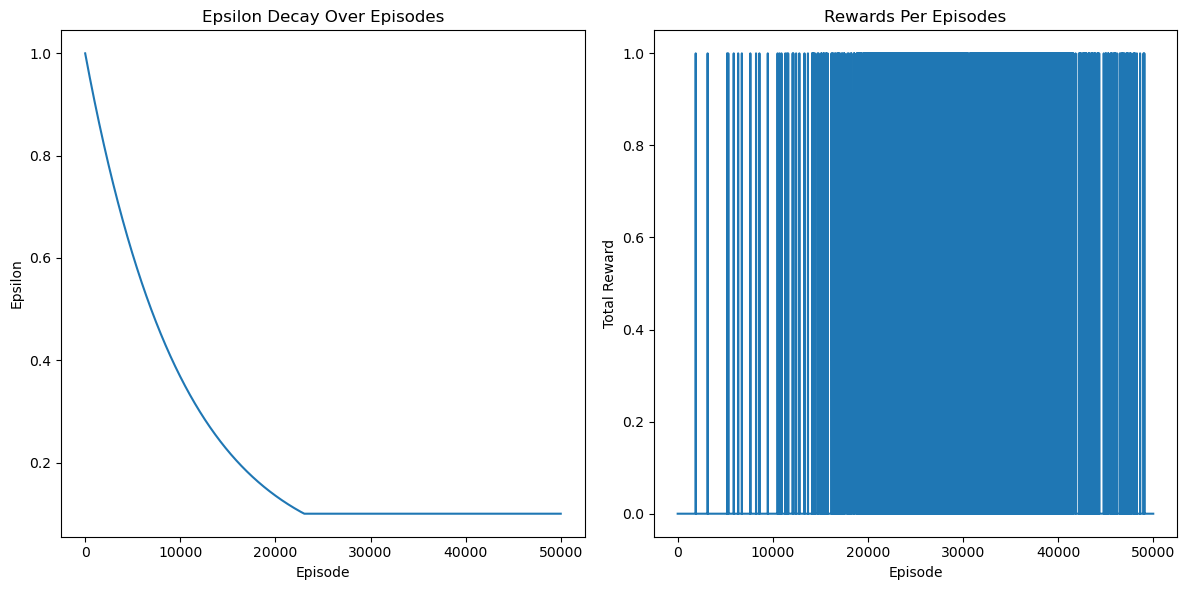

In [16]:
# Libraries for environments
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

# Libraries for output display and plotting
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque 
from tqdm import tqdm
import matplotlib.pyplot as plt

# Generate a random map and create the Frozen Lake environment with is_slippery=True
random_map = generate_random_map(size=5, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# Wrap the environment with RecordVideo to capture video after training
# env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: (x+1) % 10 == 0)

# Parameters
state_size = env.observation_space.n  # Number of states
action_size = env.action_space.n      # Number of actions
learning_rate = 0.001

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Initialize the DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Experience replay parameters
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# Epsilon-greedy parameters
epsilon = 1.0        # Exploration rate (starts high)
epsilon_min = 0.1    # Minimum exploration rate
epsilon_decay = 0.9999 # Decay rate for epsilon

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # Best action based on Q-values

# Training parameters
num_episodes = 50000  # Number of episodes to train
gamma = 0.99         # Discount factor

epsilon_values = []
reward_values = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # One-hot encoding of initial state
    total_reward = 0
    done = False

    for step in range(100):
        # Choose action
        action = choose_action(state, epsilon)

        # Take action and observe results
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  # One-hot encoding of next state

        # Modified reward structure example
        if done and reward == 0:  # Fell into a hole
            reward = 0
        elif done and reward == 1:  # Reached the goal
            reward = 1

        # Store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state
        total_reward += reward

        # Sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # Predict Q-values for current states and next states
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # Compute target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            # Compute the loss and update the network
            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Store values
    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    # # Display results occasionally
    # if (episode + 1) % 10 == 0:
    #     tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

print("Training completed.")

# Plotting
plt.figure(figsize=(12, 6))

# Plot epsilon values
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# Plot reward values
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [56]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: True)

# Run a post-training episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # Exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  # Display final reward

# Function to display the video in Jupyter Notebook
def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')

# Locate the recorded video
import os
from pathlib import Path

video_path = sorted(Path('./video2').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/Matka/video2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_64187/632396392.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = model(torch.tensor(state, dtype=torch.float32))


MoviePy - Building video /Users/Matka/video2/rl-video-episode-0.mp4.
MoviePy - Writing video /Users/Matka/video2/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/Matka/video2/rl-video-episode-0.mp4
Total Reward in test episode: 1.0


### 8x8

In [18]:
# # delete video folder
# import shutil
# folder_path = "./video3"  # Adjust this to the exact path of the folder
# shutil.rmtree(folder_path)

In [4]:
# Libraries for environments
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

# Libraries for output display and plotting
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque 
from tqdm import tqdm
import matplotlib.pyplot as plt

# Generate a random map and create the Frozen Lake environment with is_slippery=True
random_map = generate_random_map(size=8, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# Wrap the environment with RecordVideo to capture video after training
# env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: (x+1) % 10 == 0)

# Parameters
state_size = env.observation_space.n  # Number of states
action_size = env.action_space.n      # Number of actions
learning_rate = 0.001

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Initialize the DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Experience replay parameters
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# Epsilon-greedy parameters
epsilon = 1.0        # Exploration rate (starts high)
epsilon_min = 0.1    # Minimum exploration rate
epsilon_decay = 0.99999 # Decay rate for epsilon

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # Best action based on Q-values

# Training parameters
num_episodes = 100000  # Number of episodes to train
gamma = 0.99         # Discount factor

epsilon_values = []
reward_values = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # One-hot encoding of initial state
    total_reward = 0
    done = False

    for step in range(100):
        # Choose action
        action = choose_action(state, epsilon)

        # Take action and observe results
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  # One-hot encoding of next state

        # Modified reward structure example
        if done and reward == 0:  # Fell into a hole
            reward = 0
        elif done and reward == 1:  # Reached the goal
            reward = 1

        # Store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state
        total_reward += reward

        # Sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # Predict Q-values for current states and next states
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # Compute target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            # Compute the loss and update the network
            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Store values
    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    # Display results occasionally
    # if (episode + 1) % 10 == 0:
    #     tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

    if total_reward == 1:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}") 

print("Training completed.")

# # Plotting
# plt.figure(figsize=(12, 6))

# # Plot epsilon values
# plt.subplot(1, 2, 1)
# plt.plot(epsilon_values)
# plt.title('Epsilon Decay Over Episodes')
# plt.xlabel('Episode')
# plt.ylabel('Epsilon')

# # Plot reward values
# plt.subplot(1, 2, 2)
# plt.plot(reward_values)
# plt.title('Rewards Per Episodes')
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')

# plt.tight_layout()
# plt.show()

Progress:   0%|                                      | 0/100000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_15722/299282814.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
Progress:  17%|████▎                     | 16503/100000 [05:39<33:49, 41.15it/s]

Episode: 16498, Total Reward: 1.0, Epsilon: 0.8479099626863316


Progress: 100%|█████████████████████████| 100000/100000 [31:00<00:00, 53.76it/s]

Training completed.


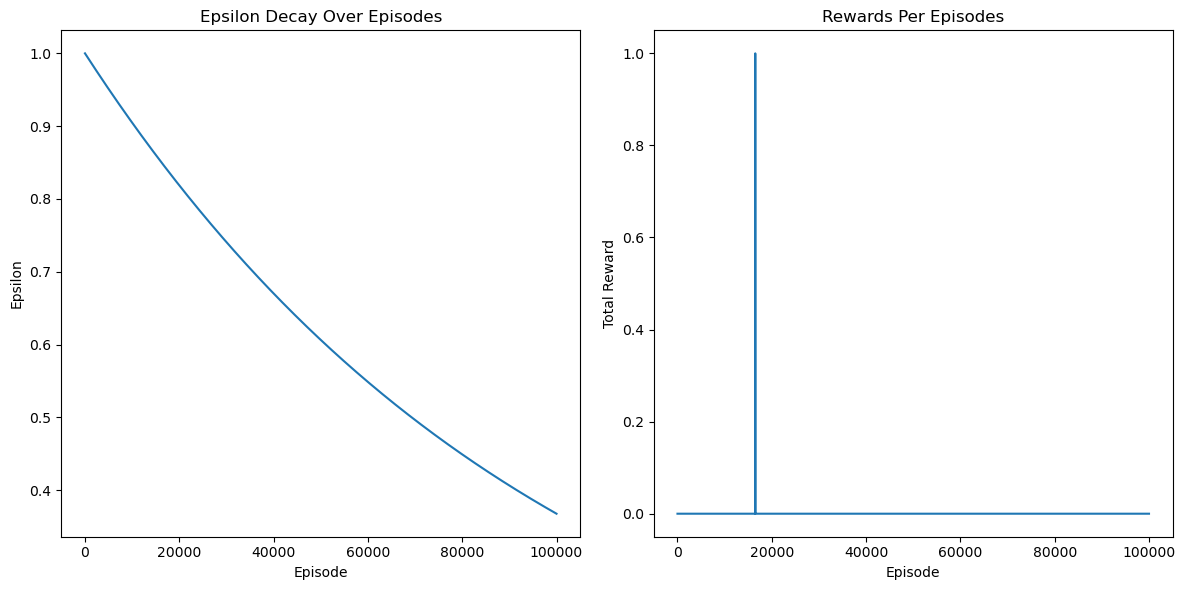

In [5]:
# Plotting for 8x8 grid
plt.figure(figsize=(12, 6))

# Plot epsilon values
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# Plot reward values
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [ ]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video3', episode_trigger=lambda x: True)

# Run a post-training episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # Exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  # Display final reward

# Function to display the video in Jupyter Notebook
def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')

# Locate the recorded video
import os
from pathlib import Path

video_path = sorted(Path('./video3').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

### 8x8 more episodes

In [ ]:
# Libraries for environments
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

# Libraries for output display and plotting
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque 
from tqdm import tqdm
import matplotlib.pyplot as plt

# Generate a random map and create the Frozen Lake environment with is_slippery=True
random_map = generate_random_map(size=8, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# Wrap the environment with RecordVideo to capture video after training
# env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: (x+1) % 10 == 0)

# Parameters
state_size = env.observation_space.n  # Number of states
action_size = env.action_space.n      # Number of actions
learning_rate = 0.001

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# Initialize the DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Experience replay parameters
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# Epsilon-greedy parameters
epsilon = 1.0        # Exploration rate (starts high)
epsilon_min = 0.1    # Minimum exploration rate
epsilon_decay = 0.99999 # Decay rate for epsilon

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # Best action based on Q-values

# Training parameters
num_episodes = 500000  # Number of episodes to train
gamma = 0.99         # Discount factor

epsilon_values = []
reward_values = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # One-hot encoding of initial state
    total_reward = 0
    done = False

    for step in range(100):
        # Choose action
        action = choose_action(state, epsilon)

        # Take action and observe results
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  # One-hot encoding of next state

        # Modified reward structure example
        if done and reward == 0:  # Fell into a hole
            reward = 0
        elif done and reward == 1:  # Reached the goal
            reward = 1

        # Store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state
        total_reward += reward

        # Sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # Predict Q-values for current states and next states
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # Compute target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            # Compute the loss and update the network
            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Store values
    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    # Display results occasionally
    if (episode + 1) % 1000 == 0:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

    if total_reward == 1:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}") 

print("Training completed.")

# # Plotting
# plt.figure(figsize=(12, 6))

# # Plot epsilon values
# plt.subplot(1, 2, 1)
# plt.plot(epsilon_values)
# plt.title('Epsilon Decay Over Episodes')
# plt.xlabel('Episode')
# plt.ylabel('Epsilon')

# # Plot reward values
# plt.subplot(1, 2, 2)
# plt.plot(reward_values)
# plt.title('Rewards Per Episodes')
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')

# plt.tight_layout()
# plt.show()

Progress:   0%|                         | 1006/500000 [00:18<2:19:35, 59.58it/s]

Episode: 1000, Total Reward: 0.0, Epsilon: 0.9900497842463938


Progress:   0%|                         | 2003/500000 [00:37<2:53:18, 47.89it/s]

Episode: 2000, Total Reward: 0.0, Epsilon: 0.980198575286327


Progress:   1%|▏                        | 3009/500000 [00:55<2:34:56, 53.46it/s]

Episode: 3000, Total Reward: 0.0, Epsilon: 0.970445387980849


Progress:   1%|▏                        | 3575/500000 [01:06<2:19:57, 59.11it/s]

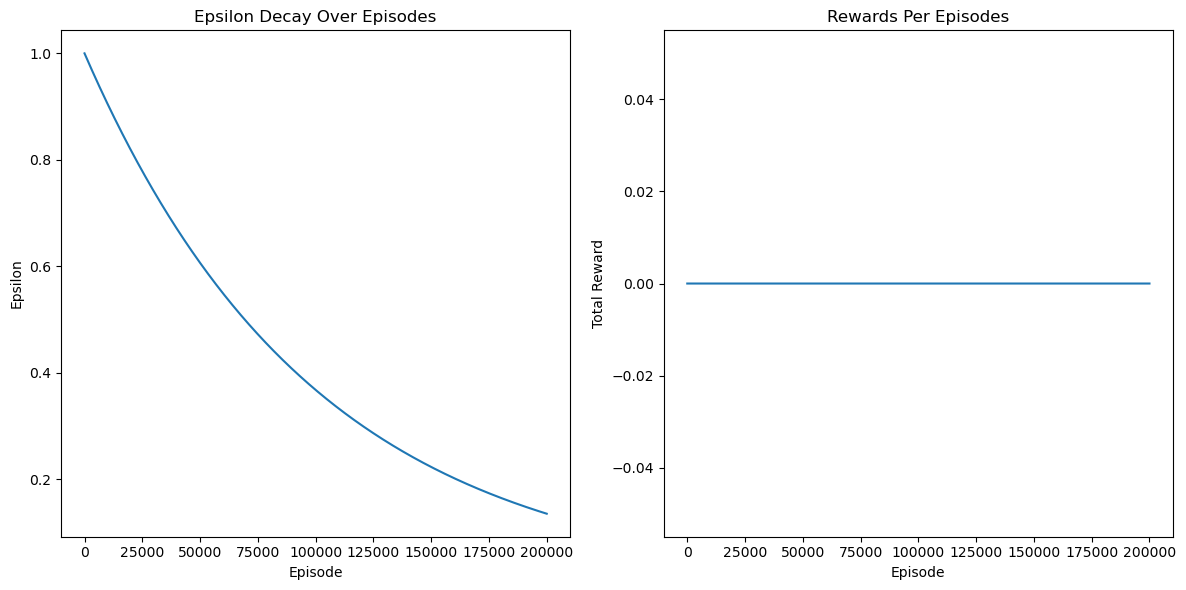

In [4]:
# Plotting for 8x8 grid
plt.figure(figsize=(12, 6))

# Plot epsilon values
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# Plot reward values
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()